In [246]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from joblib import dump, load

tf.random.set_seed(42)

data = '231116_1108_4kPa_6.5V_3line_Data'
dataname = data+'_B12'
filename = 'myData/'+data+'.csv'
SDreal = pd.read_csv(filename)
SDreal=SDreal.iloc[:,:40]
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Sx10,Sx11,...,Sx46,Sx47,Sx50,Sx51,Sx52,Sx53,Force,z,theta,r
count,119797.000000,119797.000000,119797.000000,119797.000000,119797.000000,119797.000000,119797.000000,119797.000000,119797.000000,119797.000000,...,119797.000000,119797.000000,119797.000000,119797.000000,119797.00000,119797.000000,119797.000000,119797.000000,119797.000000,119797.000000
mean,65.423658,66.165964,63.526686,64.639093,58.037794,58.186332,60.018332,64.987303,71.523243,59.386614,...,54.210326,52.217942,58.322514,59.802817,66.53855,72.374292,68.550964,87.048883,169.977378,2.800691
std,1.274087,1.443873,1.415770,1.165902,2.308470,1.468804,1.772035,2.299390,1.299471,1.170474,...,3.064380,1.583855,1.911828,1.877990,1.47006,1.633009,68.491188,48.438896,103.757724,1.833261
min,51.790000,55.290000,50.340000,54.130000,46.130000,50.400000,48.990000,51.790000,58.710000,50.400000,...,40.760000,43.970000,46.870000,48.020000,51.70000,59.370000,-560.460000,7.000000,0.000000,0.000000
25%,64.730000,65.330000,62.840000,63.990000,56.710000,57.180000,59.050000,63.430000,70.850000,58.650000,...,51.670000,51.110000,57.020000,58.760000,65.94000,71.560000,2.950000,47.000000,80.000000,1.600000
50%,65.470000,66.210000,63.640000,64.680000,58.390000,58.040000,60.220000,65.020000,71.600000,59.410000,...,53.950000,52.240000,58.400000,60.010000,66.68000,72.560000,50.500000,87.000000,160.000000,3.200000
75%,66.210000,67.100000,64.400000,65.360000,59.770000,59.110000,61.210000,66.910000,72.330000,60.160000,...,57.050000,53.400000,59.760000,61.130000,67.41000,73.440000,112.600000,127.000000,260.000000,4.800000
max,70.030000,71.560000,68.500000,71.180000,63.550000,64.050000,66.210000,71.270000,76.020000,64.270000,...,61.300000,57.030000,64.770000,65.290000,70.55000,77.040000,397.590000,167.000000,340.000000,5.600000


In [247]:
# SDreal에서 결측값 제거
SDreal = SDreal[~SDreal.isna().any(axis=1)]

SDreal = SDreal[~((SDreal <= 0) & (SDreal.columns == "Force")).any(axis=1)]

#SDreal = SDreal[SDreal["r"] >= 0.8*1]
SDreal = SDreal[SDreal["z"] <= 166]
SDreal = SDreal[SDreal["z"] >= 8]

import numpy as np
toRad = np.pi/180.0
SDreal['cos']=np.cos(SDreal['theta']*toRad)
SDreal['sin']=np.sin(SDreal['theta']*toRad)
SDreal.describe()


,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Sx10,Sx11,...,Sx50,Sx51,Sx52,Sx53,Force,z,theta,r,cos,sin
count,94837.000000,94837.000000,94837.000000,94837.000000,94837.000000,94837.000000,94837.000000,94837.000000,94837.000000,94837.000000,...,94837.000000,94837.000000,94837.000000,94837.000000,94837.000000,94837.000000,94837.000000,94837.000000,94837.000000,9.483700e+04
mean,65.402898,66.169067,63.540924,64.644090,58.000670,58.250628,60.004689,64.899776,71.535496,59.388211,...,58.338477,59.759329,66.520522,72.350798,85.391192,87.053734,169.969316,3.200337,-0.000102,2.320934e-04
std,1.321843,1.455459,1.456540,1.187499,2.387035,1.456894,1.798949,2.353386,1.325388,1.190248,...,1.920704,1.941318,1.547806,1.688080,66.952797,43.815392,103.754542,1.600346,0.707191,7.070296e-01
min,51.790000,55.290000,50.340000,54.130000,46.130000,50.400000,48.990000,51.790000,58.710000,50.400000,...,46.870000,48.020000,51.700000,59.370000,1.230000,15.000000,0.000000,0.800000,-1.000000,-9.848078e-01
25%,64.710000,65.370000,62.870000,64.010000,56.630000,57.260000,59.050000,63.350000,70.890000,58.650000,...,57.050000,58.730000,65.930000,71.560000,29.510000,47.000000,80.000000,1.600000,-0.766044,-6.427876e-01
50%,65.460000,66.230000,63.670000,64.690000,58.380000,58.100000,60.230000,64.910000,71.620000,59.420000,...,58.430000,59.990000,66.690000,72.570000,73.760000,87.000000,160.000000,3.200000,-0.173648,1.224647e-16
75%,66.220000,67.100000,64.430000,65.370000,59.800000,59.170000,61.210000,66.880000,72.340000,60.170000,...,59.770000,61.120000,67.430000,73.440000,129.970000,127.000000,260.000000,4.800000,0.766044,6.427876e-01
max,70.030000,71.560000,68.500000,71.180000,63.550000,63.780000,66.210000,71.270000,75.800000,64.270000,...,64.770000,65.290000,70.550000,76.840000,397.590000,159.000000,340.000000,5.600000,1.000000,9.848078e-01


In [248]:
NUMSEN = 36
# 24개의 특성에 대한 평균과 표준편차를 계산합니다.
mean_values = SDreal.iloc[:, :NUMSEN].mean().values
std_values = SDreal.iloc[:, :NUMSEN].std().values

mean_values = [round(value, 2) for value in mean_values]
std_values = [round(value, 2) for value in std_values]

print("float Xmean[36] = {", ", ".join(map(str, mean_values)), "};")
print("float Xstd[36] = {", ", ".join(map(str, std_values)), "};")



min_max_F = [round(SDreal.iloc[:, NUMSEN].min(), 2), round(SDreal.iloc[:, NUMSEN].max(), 2)]
min_max_Z = [round(SDreal.iloc[:, NUMSEN+1].min(), 2), round(SDreal.iloc[:, NUMSEN+1].max(), 2)]

print("float Fminmax[2]={", ", ".join(map(str, min_max_F)), "};")

print("float Zminmax[2]={", ", ".join(map(str, min_max_Z)), "};")

float Xmean[36] = { 65.4, 66.17, 63.54, 64.64, 58.0, 58.25, 60.0, 64.9, 71.54, 59.39, 66.76, 65.7, 62.38, 52.27, 59.78, 57.0, 55.41, 43.33, 52.79, 59.45, 56.31, 57.6, 64.57, 59.42, 68.92, 68.0, 67.87, 62.91, 59.91, 50.65, 54.16, 52.24, 58.34, 59.76, 66.52, 72.35 };
float Xstd[36] = { 1.32, 1.46, 1.46, 1.19, 2.39, 1.46, 1.8, 2.35, 1.33, 1.19, 1.36, 1.4, 2.24, 2.49, 2.04, 2.07, 2.24, 2.2, 2.23, 2.14, 2.22, 2.06, 2.06, 2.39, 1.67, 1.44, 1.58, 1.71, 1.51, 1.51, 3.07, 1.6, 1.92, 1.94, 1.55, 1.69 };
float Fminmax[2]={ 1.23, 397.59 };
float Zminmax[2]={ 15, 159 };


In [249]:
def apply_transformation(df, columns, transformation):
    # columns가 제공되지 않았다면 df의 모든 칼럼을 대상으로 함
    if columns is None:
        columns = df.columns
    for column in columns:
        df[column] = transformation(df[column])
    return df

def normalize(column):
    return (column - column.min()) / (column.max() - column.min())
def standardize(column):
    return (column - column.mean()) / column.std()
def submean(column):
    return (column - column.mean())
def normalize_to_neg1_to_1(column):
    normalized = (column - column.min()) / (column.max() - column.min())  # Min-Max normalization (0 to 1)
    return (normalized - 0.5) * 2  # Transform to -1 to 1


SDreal = apply_transformation(SDreal.copy(), ['r', 'Force', 'z'], normalize_to_neg1_to_1)
SDreal

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Sx10,Sx11,...,Sx50,Sx51,Sx52,Sx53,Force,z,theta,r,cos,sin
5738,65.54,64.99,64.16,64.44,60.14,57.57,62.22,67.30,69.99,59.74,...,59.01,60.91,66.83,73.14,-0.880210,-1.0,0,-1.0,1.000000,0.00000
5739,64.95,65.16,63.97,64.53,60.78,57.48,62.18,66.92,70.15,59.28,...,59.50,61.42,66.86,72.78,-0.880412,-1.0,0,-1.0,1.000000,0.00000
5740,65.13,65.30,63.64,64.44,60.65,57.23,62.15,66.76,70.46,59.57,...,58.92,61.85,67.55,72.82,-0.881572,-1.0,0,-1.0,1.000000,0.00000
5741,65.27,65.08,62.87,64.37,60.54,56.86,62.46,67.14,70.55,59.81,...,58.60,62.38,67.63,71.85,-0.881623,-1.0,0,-1.0,1.000000,0.00000
5742,64.89,65.07,62.05,64.14,60.79,57.55,62.22,67.11,69.96,59.84,...,58.67,61.15,67.02,72.04,-0.881421,-1.0,0,-1.0,1.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114090,64.51,67.58,65.81,64.09,59.15,57.83,60.77,65.41,72.10,57.18,...,58.43,57.41,66.98,71.50,-0.653547,1.0,340,1.0,0.939693,-0.34202
114091,64.75,67.65,65.17,64.41,58.96,58.03,60.81,65.51,72.25,57.15,...,58.52,57.51,67.15,71.92,-0.654657,1.0,340,1.0,0.939693,-0.34202
114092,64.46,67.54,64.81,64.51,58.63,58.52,60.51,65.92,72.04,57.46,...,58.60,57.76,66.62,72.10,-0.655313,1.0,340,1.0,0.939693,-0.34202
114093,64.72,67.45,64.34,64.42,58.36,58.10,60.76,65.93,71.87,57.38,...,58.67,57.63,66.19,71.92,-0.655515,1.0,340,1.0,0.939693,-0.34202


In [250]:
SDy = SDreal.iloc[:,36:42]
X = SDreal.iloc[:,0:36]
y = SDreal.iloc[:,[36,37,40,41]]

In [251]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.01, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state=42)
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  75110 ea 79 %    X_valid:  18778 ea 19 %    X_test:  949 ea 1 %


In [252]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/231116_1108_4kPa_6.5V_3line_Data_B12_SS.pkl']

In [253]:
from tensorflow import keras
model = keras.models.Sequential([  
    keras.layers.Dense(512, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),            
    keras.layers.Dense(128, activation="relu", kernel_initializer = "he_normal"),                           
    keras.layers.Dense(32, activation="relu", kernel_initializer = "he_normal"),                           
    keras.layers.Dense(8, activation="relu", kernel_initializer = "he_normal"),                           
    keras.layers.Dense(4)    
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 512)               18944     
                                                                 
 dense_86 (Dense)            (None, 128)               65664     
                                                                 
 dense_87 (Dense)            (None, 32)                4128      
                                                                 
 dense_88 (Dense)            (None, 8)                 264       
                                                                 
 dense_89 (Dense)            (None, 4)                 36        
                                                                 
Total params: 89,036
Trainable params: 89,036
Non-trainable params: 0
_________________________________________________________________


## Callback (best, early stopping, tensorboard)

In [254]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'231006_Data')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [255]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [256]:
dataname

'231116_1108_4kPa_6.5V_3line_Data_B12'

In [257]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
n_epochs = 300
batch_size = 8
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle,early_stopping_cb,tensorboard_cb])
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:5]
y_pred = model.predict(X_new)

Epoch 1/300
2348/2348 [==============================] - 11s 5ms/step - loss: 0.1361 - val_loss: 0.0824
Epoch 2/300
2348/2348 [==============================] - 11s 5ms/step - loss: 0.0680 - val_loss: 0.0677
Epoch 3/300
2348/2348 [==============================] - 11s 5ms/step - loss: 0.0518 - val_loss: 0.0534
Epoch 4/300
2348/2348 [==============================] - 11s 4ms/step - loss: 0.0426 - val_loss: 0.0528
Epoch 5/300
2348/2348 [==============================] - 11s 5ms/step - loss: 0.0368 - val_loss: 0.0489
Epoch 6/300
2348/2348 [==============================] - 11s 4ms/step - loss: 0.0329 - val_loss: 0.0403
Epoch 7/300
2348/2348 [==============================] - 11s 5ms/step - loss: 0.0296 - val_loss: 0.0474
Epoch 8/300
2348/2348 [==============================] - 10s 4ms/step - loss: 0.0279 - val_loss: 0.0335
Epoch 9/300
2348/2348 [==============================] - 10s 4ms/step - loss: 0.0263 - val_loss: 0.0495
Epoch 10/300
2348/2348 [==============================] - 11s 5m

In [258]:
# %load_ext tensorboard
# %tensorboard --logdir=./mylog/230320_Data --port=2322

In [259]:
model.save('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/TACTS/TACTS_v3/myModel/'+dataname+'.h5')

In [260]:
model = tf.keras.models.load_model('myModel/'+dataname+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)

valid_predictions_df=pd.DataFrame(valid_predictions)
#valid_predictions_df.columns = ["valid_force","valid_z"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r"]
valid_predictions_df.columns = ["valid_force","valid_z","valid_cos","valid_sin"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r","valid_cos","valid_sin"]
valid_theta_rad = np.arctan2(valid_predictions_df['valid_sin'], valid_predictions_df['valid_cos'])
valid_theta_deg = np.degrees(valid_theta_rad)
valid_predictions_df['valid_theta'] = valid_theta_deg
valid_predictions_df['valid_theta'] /= 180
valid_predictions_df['valid_square'] = valid_predictions_df['valid_cos']**2 + valid_predictions_df['valid_sin']**2
valid_predictions_df.describe()

587/587 [==============================] - 1s 2ms/step


,valid_force,valid_z,valid_cos,valid_sin,valid_theta,valid_square
count,18778.000000,18778.000000,18778.000000,18778.000000,18778.000000,18778.000000
mean,-0.596469,0.094431,0.024710,0.024694,0.015843,0.912701
std,0.342838,0.647893,0.667837,0.682291,0.570236,0.188351
min,-1.301574,-1.431517,-1.332567,-1.156445,-0.999748,0.000099
25%,-0.853152,-0.458960,-0.585020,-0.625360,-0.432077,0.839030
50%,-0.642832,0.127037,0.007458,-0.027553,-0.012081,0.930102
75%,-0.389501,0.660089,0.687767,0.712487,0.532146,1.024310
max,1.201889,1.503087,1.181174,1.166539,0.999969,1.947318


In [261]:
k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
k_df.columns  = ["force","z","cos","sin"]
#k_df.columns  = ["force","z","r","cos","sin"]
theta_rad = np.arctan2(k_df['sin'], k_df['cos'])
theta_deg = np.degrees(theta_rad)
k_df['theta'] = theta_deg
k_df['theta'] /= 180
k_df['square'] = k_df['cos']*k_df['cos'] + k_df['sin']*k_df['sin']
k_df

,force,z,cos,sin,theta,square
0,-0.194621,-0.777778,1.000000,0.000000,0.000000,1.0
1,-0.898173,-0.666667,-0.173648,0.984808,0.555556,1.0
2,-0.998890,0.444444,-0.173648,0.984808,0.555556,1.0
3,-0.510697,-0.333333,0.939693,0.342020,0.111111,1.0
4,-0.859623,1.000000,-0.500000,0.866025,0.666667,1.0
...,...,...,...,...,...,...
18773,-0.665102,-0.777778,-0.766044,0.642788,0.777778,1.0
18774,-0.648300,-0.444444,-0.939693,-0.342020,-0.888889,1.0
18775,-0.532142,0.555556,-0.500000,-0.866025,-0.666667,1.0
18776,-0.409829,0.666667,0.173648,0.984808,0.444444,1.0


In [262]:
ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
n = k_df.shape[1]
for i in range(0,n):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr_matrix = pd.DataFrame(index=k_df.columns, columns=valid_predictions_df.columns)

# 각 열과 행의 상관관계 계산
for k_col in k_df.columns:
    for valid_col in valid_predictions_df.columns:
        corr2 = np.corrcoef(k_df[k_col], valid_predictions_df[valid_col])[0, 1]
        corr_matrix.loc[k_col, valid_col] = corr2
corr_matrix

corr
90.64% force
97.65% z
97.03% cos
97.41% sin
85.87% theta
2.39% square


,valid_force,valid_z,valid_cos,valid_sin,valid_theta,valid_square
force,0.906372,-0.359411,0.335,-0.156591,-0.12656,0.140582
z,-0.434296,0.976476,0.083383,0.037438,0.037344,0.014644
cos,0.425453,-0.012871,0.970272,-0.034771,-0.02979,0.231881
sin,-0.245397,0.01127,-0.019437,0.974076,0.759445,0.136896
theta,-0.248176,0.022861,-0.135704,0.762954,0.858716,0.177785
square,0.163675,-0.002668,0.210355,-0.278087,-0.189074,0.02513


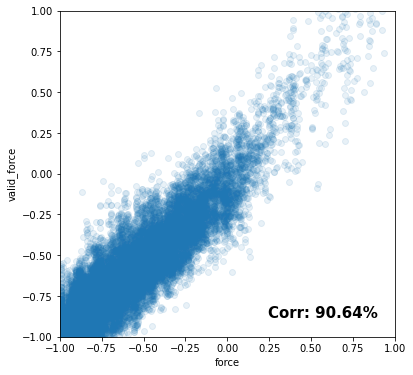

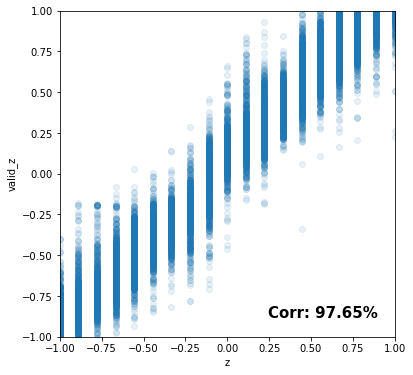

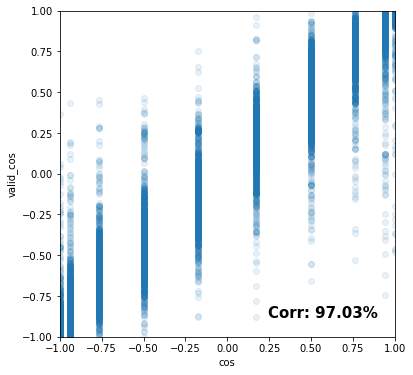

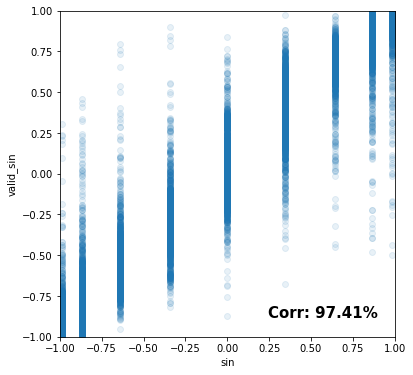

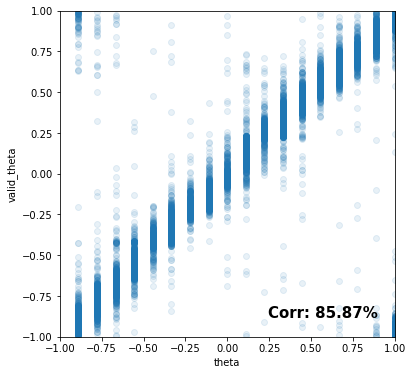

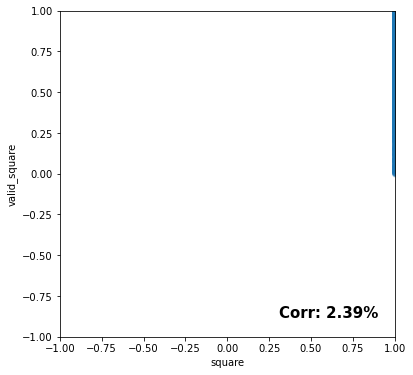

In [263]:
import pandas as pd
import os
import matplotlib.pyplot as plt

alpa = 0.1
output_dir = "myLearningData/savefig"  # 저장할 폴더 이름

# 폴더가 없는 경우 폴더를 생성합니다.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

fields = ['force','z','cos','sin','theta','square']
#fields = ['force','z','r','cos','sin','theta']

for field in fields:
    plt.figure(figsize=(6, 6))  # Set the figure size to 1:1
    plt.scatter(ValidPre[field], ValidPre[f"valid_{field}"], alpha=alpa)
    plt.xlabel(field)
    plt.ylabel(f"valid_{field}")
    plt.xlim(-1, 1)  # x축 범위 설정
    plt.ylim(-1, 1)  # y축 범위 설정

    # Compute the correlation value to be added
    corr_value = format(corr[f"valid_{field}"][field]*100,'.2f') + '%'
    plt.text(0.95, 0.05, f'Corr: {corr_value}', ha='right', va='bottom', 
             transform=plt.gca().transAxes, fontsize=15, weight='bold')

    plt.savefig(os.path.join(output_dir, f"{dataname}_{field}.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장
    plt.show()


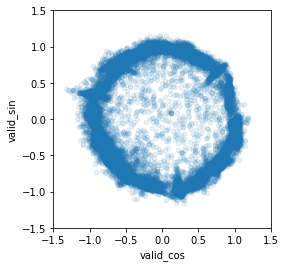

In [264]:
alpa = 0.1  # assuming you've set alpha to this value, adjust as needed
ax = ValidPre.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpa)

# Set the aspect ratio to be equal
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장

# Display the plot
plt.show()

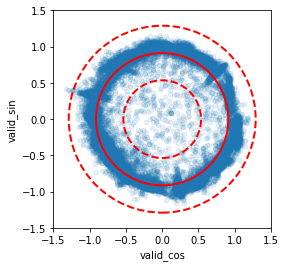

In [265]:
alpha = 0.1  # set alpha value for scatter plot
ax = ValidPre.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpha)


# Draw offset circles (one inside and one outside the main circle)
n = 2  # adjust the offset value as needed
avg = valid_predictions_df['valid_square'].mean()
std = valid_predictions_df['valid_square'].std()

circle = plt.Circle((0, 0), avg, color='r', fill=False, linewidth=2)
ax.add_artist(circle)
inner_circle = plt.Circle((0, 0), avg - n*std, color='r', linestyle='--', fill=False, linewidth=2)
outer_circle = plt.Circle((0, 0), avg + n*std, color='r', linestyle='--', fill=False, linewidth=2)
ax.add_artist(inner_circle)
ax.add_artist(outer_circle)

# Set the aspect ratio to be equal
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정
# Display the plot
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle_offset.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장

plt.show()


In [266]:
print(avg,std,avg - n*std,avg + n*std)

0.9127014875411987 0.1883511245250702 0.5359992384910583 1.2894037365913391


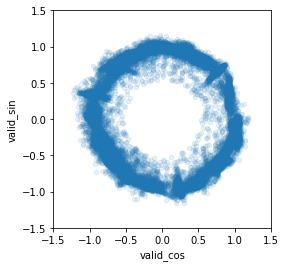

1.656193417829375

In [267]:
ValidPre_filtered = ValidPre[
    (ValidPre['valid_cos']**2 + ValidPre['valid_sin']**2 <= (avg + n*std)**2) &
    (ValidPre['valid_cos']**2 + ValidPre['valid_sin']**2 >= (avg - n*std)**2)
]


ax = ValidPre_filtered.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpha)
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle_cut.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장

plt.show()

total_data_count = len(ValidPre)
filtered_data_count = len(ValidPre_filtered)
percentage_filtered_out = ((total_data_count - filtered_data_count) / total_data_count) * 100
percentage_filtered_out

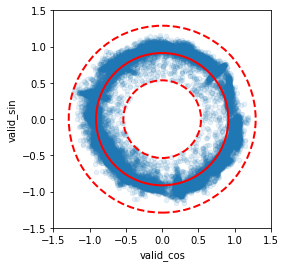

In [268]:
# 기존의 scatter plot을 그립니다.
ax = ValidPre_filtered.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpha)



# 점선 원을 추가합니다. 하나는 내부에, 하나는 외부에 위치합니다.
circle = plt.Circle((0, 0), avg, color='r', fill=False, linewidth=2)
inner_circle = plt.Circle((0, 0), avg - n*std, color='r', linestyle='--', fill=False, linewidth=2)
outer_circle = plt.Circle((0, 0), avg + n*std, color='r', linestyle='--', fill=False, linewidth=2)
ax.add_artist(circle)
ax.add_artist(inner_circle)
ax.add_artist(outer_circle)

# 그래프의 비율을 1:1로 설정합니다.
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정

# 그래프를 파일로 저장합니다.
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle_cut_offset.png"))

# 그래프를 출력합니다.
plt.show()
